## Load Data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sksurv.datasets import get_x_y
from sklearn.utils import resample
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test

import joblib

import warnings
warnings.filterwarnings('ignore')

In [29]:
data = pd.read_excel("validation_dataset.xlsx")
data

,Age,Menopausal,Hormone_Resistance_Primary,Hormone_Resistance_Secondary,ER,PgR,HER2,Ki67,Histotype,M_Brain,M_Liver,M_Bone,M_Peritoneal,Bone_Only,Sinc,PD,PFS
0,46.5,0.0,0,1,90.0,90.0,1,35.0,1.0,0,1,1,0,0,0.0,1,13.1
1,61.6,1.0,0,1,90.0,90.0,1,20.0,0.0,0,1,0,0,0,0.0,0,42.8
2,49.5,0.0,1,0,90.0,80.0,0,15.0,0.0,0,0,1,0,0,0.0,1,13.9
3,50.5,1.0,1,0,60.0,0.0,1,25.0,0.0,0,1,0,0,0,0.0,1,2.1
4,70.3,1.0,0,1,90.0,90.0,0,30.0,1.0,0,0,1,0,1,0.0,1,33.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,51.9,1.0,0,0,85.0,70.0,1,25.0,0.0,0,0,1,0,1,0.0,0,11.7
134,48.8,0.0,0,0,90.0,75.0,0,25.0,0.0,0,1,1,0,0,1.0,0,51.8
135,60.6,1.0,0,0,95.0,75.0,1,6.0,0.0,0,0,1,0,0,1.0,0,11.5
136,74.6,1.0,0,0,95.0,95.0,1,22.0,0.0,0,0,0,0,0,0.0,0,48.5


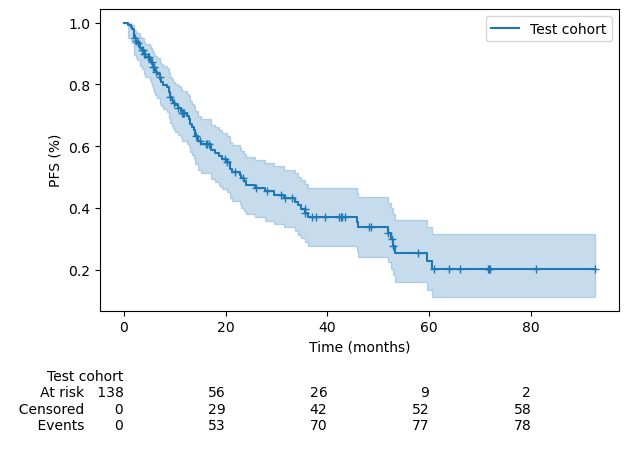

In [19]:
# Initialize and fit KM fitter
kmf = KaplanMeierFitter()
kmf.fit(durations=data["PFS"], event_observed=data["PD"], label="Test cohort")

# Plot survival curve
ax = kmf.plot_survival_function(ci_show=True, show_censors = True, censor_styles={'ms': 6})   # with confidence interval
plt.xlabel("Time (months)")
plt.ylabel("PFS (%)")
plt.title("")
add_at_risk_counts(kmf, ax=ax)

plt.tight_layout()
plt.show()

In [20]:
# Median survival and 95% CI
median_surv = kmf.median_survival_time_
median_ci = median_survival_times(kmf.confidence_interval_)

print(f"Median PFS: {median_surv:.2f} months")
print("95% CI for median survival:")
print(median_ci)

Median PFS: 23.00 months
95% CI for median survival:
     Test cohort_lower_0.95  Test cohort_upper_0.95
0.5                    17.2                    34.8


In [21]:
df = data.copy()
# Define the column names for event and time (PFS and PFS_Months)
attr_labels = ['PD', 'PFS']  # Replace with your actual column names
# Get the features (X) and survival labels (y) using get_x_y
X, y = get_x_y(data, attr_labels, survival=True, pos_label=1)

# Models

### Coxnet

In [22]:
coxnet_model = joblib.load('coxnet_model.joblib')
coxnet_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'ER', 'PgR', 'Ki67']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Menopausal',
                                                   'Hormone_Resistance_Primary',
                                                   'Hormone_Resistance_Secondary',
                                                   'HER2', 'Histotype',
                                                   'M_Brain', 'M_Liver',
                                                   'M_Bone', 'M_Peritoneal',
                                                   'Bone_Only', 'Sinc'])])),
                ('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.016803176364768267],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [23]:
c_index = coxnet_model.score(X, y)
print(f"Concordance Index: {c_index:.2f}")

Concordance Index: 0.74


In [24]:
n_bootstraps = 1000
rng = np.random.default_rng(42)

c_indices = []

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X, y, replace=True, random_state=rng.integers(0, 1e6))
    c_index = coxnet_model.score(X_resampled, y_resampled) # Compute C-index
    c_indices.append(c_index)
c_indices = np.array(c_indices)

# Point estimate and 95% CI
c_index = np.percentile(c_indices, [50])[0]
ci_lower, ci_upper = np.percentile(c_indices, [2.5, 97.5])
print(f"Test Concordance Index: {c_index:.2f} (95% CI: {ci_lower:.2f} – {ci_upper:.2f})")

Test Concordance Index: 0.74 (95% CI: 0.67 – 0.80)


### GBM

In [25]:
gbm_model = joblib.load('gbm_model.joblib')
gbm_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'ER', 'PgR', 'Ki67']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Menopausal',
                                                   'Hormone_Resistance_Primary',
                                                   'Hormone_Resistance_Secondary',
                                                   'HER2', 'Histotype',
                                                   'M_Brain', 'M_Liver',
                                                   'M_Bone', 'M_Peritoneal',
                                                   'Bone_Only', 'Sinc'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingsurvivalanalysis',
                 GradientBoostingSurvivalAnalysis(learning_rate=1.0,
                                                  max_depth=1, n_estimators=16,
                                                  random_state=0))])

In [26]:
c_index = gbm_model.score(X, y)
print(f"Concordance Index: {c_index:.2f}")

Concordance Index: 0.74


In [27]:
n_bootstraps = 1000
rng = np.random.default_rng(42)

c_indices = []

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X, y, replace=True, random_state=rng.integers(0, 1e6))
    c_index = gbm_model.score(X_resampled, y_resampled) # Compute C-index
    c_indices.append(c_index)
c_indices = np.array(c_indices)

# Point estimate and 95% CI
c_index = np.percentile(c_indices, [50])[0]
ci_lower, ci_upper = np.percentile(c_indices, [2.5, 97.5])
print(f"Test Concordance Index: {c_index:.2f} (95% CI: {ci_lower:.2f} – {ci_upper:.2f})")

Test Concordance Index: 0.74 (95% CI: 0.67 – 0.80)


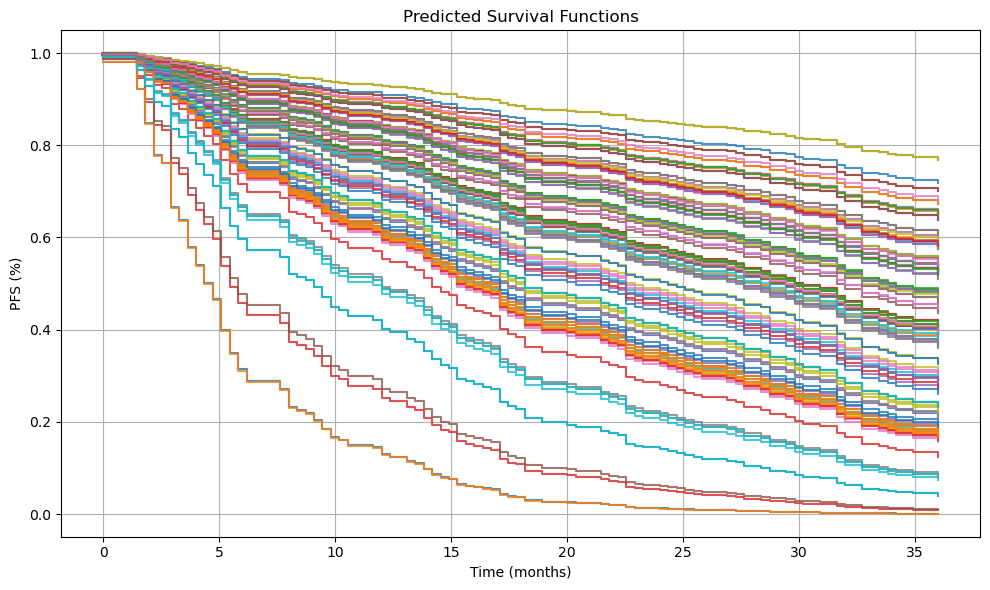

In [33]:
# Predict survival functions for all patients
surv_fns = gbm_model.predict_survival_function(X)

time_points = np.linspace(0, 36, 100)  # More resolution

_, ax = plt.subplots(figsize=(10, 6))
legend_handles = []

# Optional: only show first N patients
N = 300

for i, fn in enumerate(surv_fns[:N]):
    (line,) = ax.step(time_points, fn(time_points), where="post", alpha=0.8, label=f"Patient {i+1}")
    legend_handles.append(line)

ax.set_title("Predicted Survival Functions")
ax.set_xlabel("Time (months)")
ax.set_ylabel("PFS (%)")
ax.grid(True)
plt.tight_layout()
plt.show()

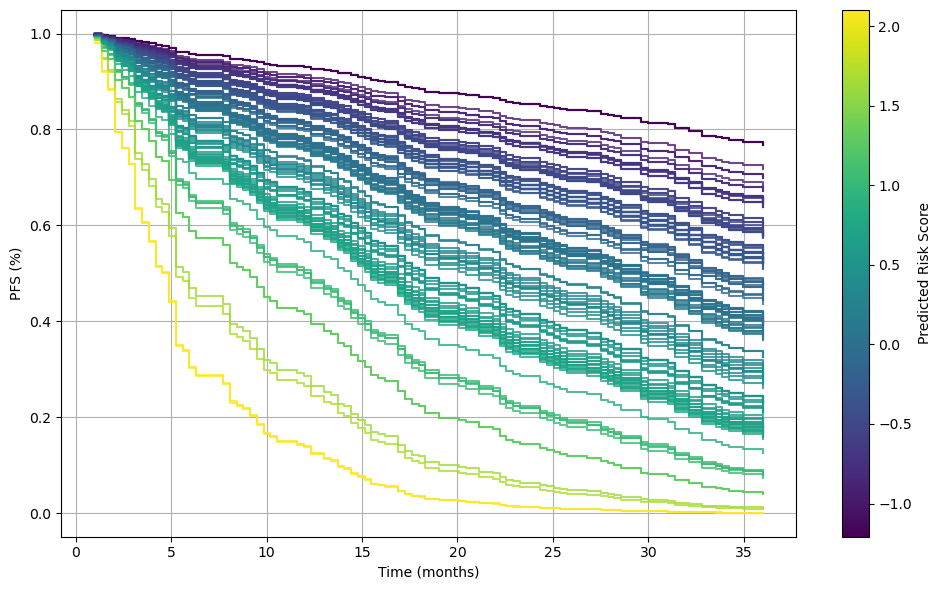

In [34]:
# Predict survival functions and risk scores
surv_fns = gbm_model.predict_survival_function(X)
risk_scores = gbm_model.predict(X)  # Higher risk = worse survival
risk_scores

# Normalize risk scores for color mapping
norm = colors.Normalize(vmin=min(risk_scores), vmax=max(risk_scores))
cmap = cm.get_cmap("viridis")  # Choose any matplotlib colormap

time_points = np.linspace(1, 36, 100)

fig, ax = plt.subplots(figsize=(10, 6))

# Optional: limit number of curves shown for readability
N = 300

for i, (fn, risk) in enumerate(zip(surv_fns[:N], risk_scores[:N])):
    color = cmap(norm(risk))  # Map risk score to color
    ax.step(time_points, fn(time_points), where="post", color=color, alpha=0.8, label=f"Risk: {risk:.2f}")

# Colorbar to interpret risk scale
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Risk Score")

ax.set_title("")
ax.set_xlabel("Time (months)")
ax.set_ylabel("PFS (%)")
ax.grid(True)
plt.tight_layout()
plt.show()

In [35]:
cutoff = 0.1432

In [36]:
# Predict risk scores from model
risk_scores = gbm_model.predict(X)  # or X_test, depending on what you want to evaluate

# Convert y to DataFrame for lifelines
y_df = pd.DataFrame({
    'PD': y['PD'].astype(int),
    'PFS': y['PFS']
})
y_df['clusters'] = (risk_scores > cutoff).astype(int)  # this becomes your binary group
cph = CoxPHFitter()
cph.fit(y_df, duration_col='PFS', event_col='PD')

print(cph.summary)

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
clusters   0.947426   2.579064  0.228069        0.500419        1.394434   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
clusters              1.649413              4.03269     0.0  4.15412   

                  p   -log2(p)  
covariate                       
clusters   0.000033  14.902375  


In [37]:
summary_df = cph.summary
hr = summary_df.loc['clusters', 'exp(coef)']
ci_lower = summary_df.loc['clusters', 'exp(coef) lower 95%']
ci_upper = summary_df.loc['clusters', 'exp(coef) upper 95%']
p_value = summary_df.loc['clusters', 'p']

print(f"HR: {hr:.2f} (95% CI: {ci_lower:.2f}, {ci_upper:.2f}), p-value: {p_value:.4f}")

HR: 2.58 (95% CI: 1.65, 4.03), p-value: 0.0000


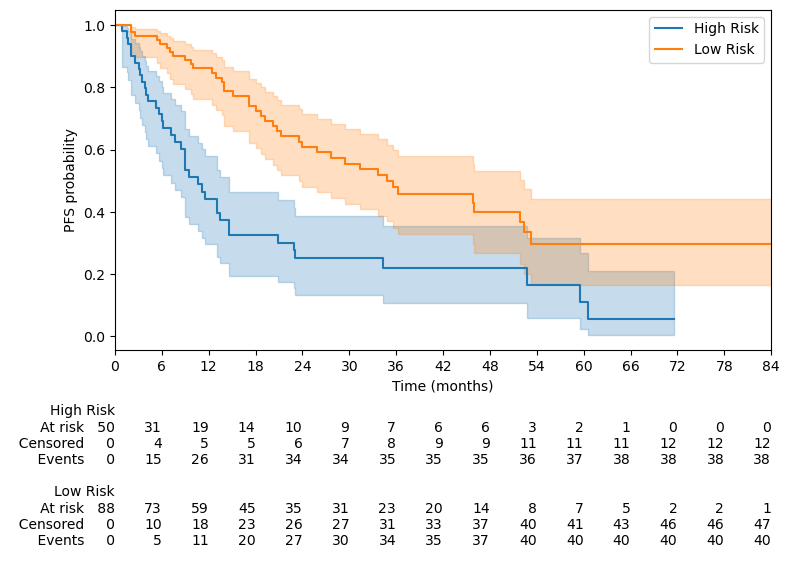

In [38]:
mask_high = y_df['clusters'] == 1
mask_low  = y_df['clusters'] == 0

# Fit KM for each group
km_high = KaplanMeierFitter().fit(
    durations=y_df.loc[mask_high, 'PFS'],
    event_observed=y_df.loc[mask_high, 'PD'],
    label='High Risk'
)
km_low = KaplanMeierFitter().fit(
    durations=y_df.loc[mask_low, 'PFS'],
    event_observed=y_df.loc[mask_low, 'PD'],
    label='Low Risk'
)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
km_high.plot_survival_function(ax=ax, ci_show=True)
km_low.plot_survival_function(ax=ax, ci_show=True)

ax.set_xticks(range(0, 90, 6))
ax.set_xlim(0, 84)
ax.set_xlabel("Time (months)")
ax.set_ylabel("PFS probability")
ax.set_title("")

add_at_risk_counts(km_high, km_low, ax=ax)

plt.tight_layout()
plt.show()

In [40]:
def bootstrap_median_ci(T, E, n_iterations=1000, ci=0.95):
    medians = []
    n = len(T)
    for _ in range(n_iterations):
        idx = np.random.choice(n, n, replace=True)
        kmf = KaplanMeierFitter()
        kmf.fit(T.iloc[idx], E.iloc[idx])
        medians.append(kmf.median_survival_time_)
    lower = np.percentile(medians, (1 - ci) / 2 * 100)
    upper = np.percentile(medians, (1 + ci) / 2 * 100)
    return lower, upper

for group in [0, 1]:
    mask = y_df['clusters'] == group
    T = y_df.loc[mask, 'PFS']
    E = y_df.loc[mask, 'PD']
    
    kmf.fit(T, event_observed=E, label=f'Group {group}')
    median_ = kmf.median_survival_time_
    
    lower, upper = bootstrap_median_ci(T, E)
    
    print(f'Group {group}: Median Survival = {median_}')
    print(f'95% CI Lower = {lower}, Upper = {upper}\n')


Group 0: Median Survival = 34.8
95% CI Lower = 24.0, Upper = 52.4

Group 1: Median Survival = 10.6
95% CI Lower = 7.2, Upper = 14.6



# Early progression

In [41]:
# Predict survival function
surv_fns_test = gbm_model.predict_survival_function(X)

# Evaluate survival probability at 6 months
target_time = 6.0
surv_at_6_months = np.array([fn(target_time) for fn in surv_fns_test])

# Predict as "high risk" if survival probability at 6 months is less than 50%
y_pred_binary = surv_at_6_months < 0.5

In [42]:
# Identify patients with event before 6 months
observed_event_mask = (y["PD"] == True) & (y["PFS"] < 6.0)
# Identify patients censored before 6 months (to be excluded)
censored_before_6_mask = (y["PD"] == False) & (y["PFS"] < 6.0)
# Exclude censored patients before 6 months
valid_indices = ~censored_before_6_mask
# Filter predictions and ground truth
y_true_binary = observed_event_mask[valid_indices]
y_pred_binary = y_pred_binary[valid_indices]

# Count number of events (True) and percentage
n_events = y_true_binary.sum()
n_total = y_true_binary.shape[0]
percent_events = (n_events / n_total) * 100

print(f'Number of Events: {n_events} out of {n_total} ({percent_events:.1f}%)')

Number of Events: 19 out of 124 (15.3%)


In [43]:
# Compute ROC-AUC and PR-AUC
y_scores = -surv_at_6_months[valid_indices]  # Negative because lower survival = higher risk
y_true_binary = observed_event_mask[valid_indices]  # True/False labels

roc_auc = roc_auc_score(y_true_binary, y_scores)
pr_auc = average_precision_score(y_true_binary, y_scores)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC: {pr_auc:.3f}")

ROC-AUC: 0.768
PR-AUC: 0.470


In [44]:
# Your original scores and labels
y_scores = -surv_at_6_months[valid_indices]  # higher = higher risk
y_true_binary = observed_event_mask[valid_indices]  # True/False

# Point estimates
roc_auc = roc_auc_score(y_true_binary, y_scores)
pr_auc = average_precision_score(y_true_binary, y_scores)

# Bootstrap
n_bootstraps = 1000
rng = np.random.default_rng(42)
roc_values, pr_values = [], []

for _ in range(n_bootstraps):
    idx = rng.choice(len(y_scores), size=len(y_scores), replace=True)
    if len(np.unique(y_true_binary[idx])) < 2:
        # skip if bootstrap sample has only one class
        continue
    roc_values.append(roc_auc_score(y_true_binary[idx], y_scores[idx]))
    pr_values.append(average_precision_score(y_true_binary[idx], y_scores[idx]))

roc_lower, roc_upper = np.percentile(roc_values, [2.5, 97.5])
pr_lower, pr_upper   = np.percentile(pr_values, [2.5, 97.5])

print(f"ROC-AUC: {roc_auc:.2f} (95% CI: {roc_lower:.2f} – {roc_upper:.2f})")
print(f"PR-AUC : {pr_auc:.2f} (95% CI: {pr_lower:.2f} – {pr_upper:.2f})")

ROC-AUC: 0.77 (95% CI: 0.61 – 0.89)
PR-AUC : 0.47 (95% CI: 0.28 – 0.70)


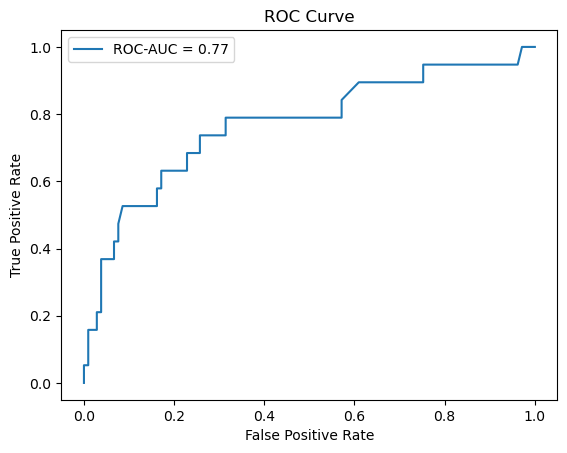

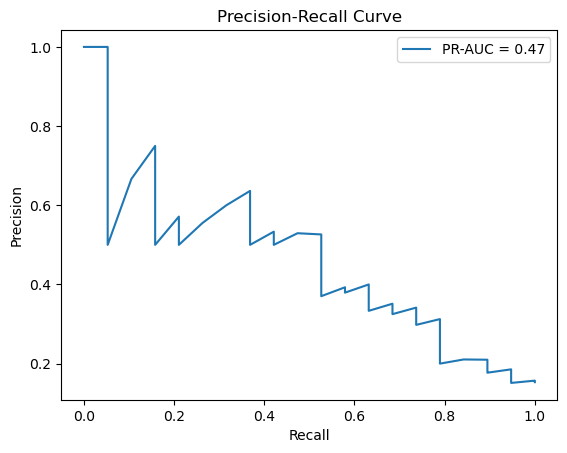

In [45]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
plt.figure()
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()